## 1. Intro
- The purpose of pre-project is to make a model to distinguish the consumer's interest according to the brand, type, usage and price of a product.

## Contents
[2. Import Package](#2.-Import-Package)  
[3. Import selectshop data](#3.-Import-selectshop-data)  
[4. Add nan](#4.-Add-nan)  
[5. Column selection](#5.-Column-selection)  
[6. Modify product category](#6.-Modify-product-category)  
[7. Value selection](#7.-Value-selection)  
[8. Labeling](#8.-Labeling)  
[9. Define X and Y](#9.-Define-X-and-Y)  
[10. Pre-processor](#10.-Pre\-processor)  
[11. Logistic regression](#11.-Logistic-regression)  
[12. DecisionTree](#12.-DecisionTree)  
[13. Ensemble(random forest)](#13.-Ensemble(random-forest))  
[14. Gradient boosting(lightgbm)](#14.-Gradient-boosting(lightgbm))  
[15. Compare the test values](#15.-Compare-the-test-values)  
[16. Final model](#16.-Final-model)  
[17. Feature importance](#17.-Feature-importance)  
[18. Practical use](#18.-Practical_use)


## 2. Import Package
- The core pakages used in this poject `sklearn` for machine learning and `lightgbm` for lightGBM

In [1]:
# basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# pre-process and pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# classificaion algorithm
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm

# test
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# etc
import warnings
warnings.simplefilter('ignore')

## 3. Import selectshop data

In [2]:
selecshop_df = pd.read_csv("datas/wconcept.csv")

In [3]:
len(selecshop_df)

3791

## 4. Add nan
- fill a blank with a value of "nan".

In [4]:
# fill 'nan' value
for i in selecshop_df.columns:
    selecshop_df["{}".format(i)] = selecshop_df["{}".format(
        i)].replace("", np.nan)

In [5]:
selecshop_df.isnull().sum()

urls                0
malls               0
gender              0
products            0
brands              0
normal_prices    1550
sale_prices         0
stars               0
make_dates         16
dtype: int64

## 5. Column selection
- Drop meaningless columns for final analysis.

In [6]:
selecshop_df = selecshop_df.drop(
    ["urls", "malls", "normal_prices", "make_dates"], axis=1)
selecshop_df = selecshop_df.dropna(axis=0)

In [7]:
selecshop_df.head(2)

,gender,products,brands,sale_prices,stars
0,LIFE,양말,POSITIVE.V,"14,400",5.0
1,LIFE,양말,POSITIVE.V,"12,800",0.0


## 6. Modify product category
- Combine similar words among the values of a product category.

In [8]:
selecshop_df["products"] = selecshop_df["products"].replace("HOODIES", "HOODIE").replace("BEANIE / BOMBER", "BEANIE").replace("CLUTCHES", "CLUTCHE").replace("JUMPERS", "JUMPER")

In [9]:
price_list = selecshop_df.sale_prices.values.tolist()

## 7. Value selection
- Drop rows with less than 50 data by a brand or a product

In [10]:
# group by to count value by a brand
selecshop_df["count"] = 1
pro_b = selecshop_df.groupby(["brands"])["count"].sum()
pro_b = pro_b.sort_values(ascending=False)

# make a brand list to drop
delete_brand = []
for i in range(0, len(pro_b)):
    if pro_b[i] < 50:
        brand = pro_b.index[i]
        delete_brand.append(brand)
        
# drop brands in the list
for word in delete_brand:
    selecshop_df["brands"] = selecshop_df["brands"].replace(
        "{}".format(word), np.nan)
selecshop_df = selecshop_df.dropna(axis=0)

In [11]:
# group by to count value by a product
pro_p = selecshop_df.groupby(["products"])["count"].sum()
pro_p = pro_b.sort_values(ascending=False)

# make a product list to drop
delete_product = []
for i in range(0, len(pro_b)):
    if pro_b[i] < 50:
        product = pro_b.index[i]
        delete_product.append(product)
        
# drop products in the list
for word in delete_product:
    selecshop_df["products"] = selecshop_df["products"].replace(
        "{}".format(word), np.nan)
selecshop_df = selecshop_df.dropna(axis=0)

In [12]:
selecshop_df.head(3)

,gender,products,brands,sale_prices,stars,count
0,LIFE,양말,POSITIVE.V,"14,400",5.0,1
1,LIFE,양말,POSITIVE.V,"12,800",0.0,1
2,LIFE,양말,POSITIVE.V,"8,900",0.0,1


## 8. Labeling
- four or more stars score were labeled with a high score of "1" and the rest with a low score of "0".

In [13]:
selecshop_df["stars"] = selecshop_df["stars"].apply(lambda x: float(x))
selecshop_df["stars"] = selecshop_df["stars"].apply(lambda x: 1 if x >= 4 else 0)

pro_s = selecshop_df.groupby(["stars"])["count"].sum()
pro_s = pro_s.sort_values(ascending=False)
print("별점(0 : 4.0 미만/ 1: 4.0 이상) \n", pro_s)

별점(0 : 4.0 미만/ 1: 4.0 이상) 
 stars
0    1955
1    1063
Name: count, dtype: int64


## 9. Define X and Y

|---|**variable**|
|---|---|
|**X**|`gender`, `products`, `brands`, `sale_prices`|
|**Y**| `star score`|

In [14]:
selecshop_df["sale_prices"] = selecshop_df["sale_prices"].str.replace(",", "").astype("int")

In [15]:
selecshop_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3018 entries, 0 to 3790
Data columns (total 6 columns):
gender         3018 non-null object
products       3018 non-null object
brands         3018 non-null object
sale_prices    3018 non-null int64
stars          3018 non-null int64
count          3018 non-null int64
dtypes: int64(3), object(3)
memory usage: 165.0+ KB


In [16]:
X = selecshop_df[['gender', 'products', 'brands', 'sale_prices']]

In [17]:
y = selecshop_df["stars"]

## 10. Pre-processor
- scale the numerical value of `sale_prices` with standard scail method and encode the categorical value of `gender`, `products`, `brands` with one hot method

In [18]:
numeric_features = ['sale_prices']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['gender', 'products', 'brands']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

## 11. Logistic regression
- model fitting and 5 fold cross validation test

In [19]:
clf_rogit = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', LogisticRegression())])

In [20]:
model_rogit = clf_rogit.fit(X, y)
cv = KFold(5, shuffle=True, random_state=0)
check_rogit = cross_val_score(
    model_rogit, X, y, scoring="accuracy", cv=cv).mean()
check_rogit

0.7813086883463478

## 12. DecisionTree

- touched parameter : max_depth(1 to 30)
- test : 5 fold validation score

In [21]:
check_tree_mean = []
check_tree_std = []
for num in range(1, 30):
    clf_tree = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', DecisionTreeClassifier(max_depth=num, random_state=0))])
    model_tree = clf_tree.fit(X, y)
    cv = KFold(5, shuffle=True, random_state=0)
    check = cross_val_score(model_tree, X, y, scoring="accuracy", cv=cv)
    check_tree_mean.append(check.mean())
    check_tree_std.append(check.std())

(0.624, 0.8)

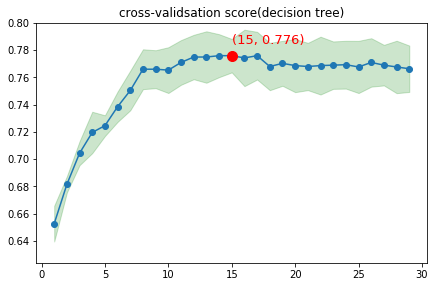

In [22]:
plt.figure(figsize=(7, 15))
plt.subplot(311)
plt.title("cross-validsation score(decision tree)")
plt.plot(range(1, 30), check_tree_mean, "o-")
plt.fill_between(range(1, 30), np.array(check_tree_mean) - np.array(check_tree_std),
                 np.array(check_tree_mean) + np.array(check_tree_std), alpha=0.2, color="g")
plt.plot(check_tree_mean.index(max(check_tree_mean))+1, max(check_tree_mean), 'ro', ms=10)
plt.text(check_tree_mean.index(max(check_tree_mean))+1, max(check_tree_mean)+0.009, "({}, {})".format(
    check_tree_mean.index(max(check_tree_mean))+1, round(max(check_tree_mean), 3)), fontdict={"size": 13, "color": "r"})
plt.ylim(0.624,0.8)

## 13. Ensemble(random forest)

- touched parameter
     - try 1 : n_estimater (1 to 300 but skip size 40), max_depth (1 to 10)
     - try 2 :  n_estimater (1 to 300 but skip size 1o), max_depth (None : nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.)
- test : 5 fold validation score

In [23]:
# make def for random forest
def extra_tree_check(list1, list2):
    check_ran_mean = []
    check_ran_std = []
    for n in list1:
        for max_depth in list2:
            clf_ran = Pipeline(steps=[('preprocessor', preprocessor),
                                      ('classifier', ExtraTreesClassifier(n_estimators=n, max_depth = max_depth, random_state=0))])
            model_ran = clf_ran.fit(X, y)
            cv = KFold(5, shuffle=True, random_state=0)
            check = cross_val_score(model_ran, X, y, scoring="accuracy", cv=cv)
            check_ran_mean.append(check.mean())
            check_ran_std.append(check.std())
    return check_ran_mean, check_ran_std

### try 1

In [24]:
check_ran_mean, check_ran_std = extra_tree_check(range(1, 300, 50), range(1,10))

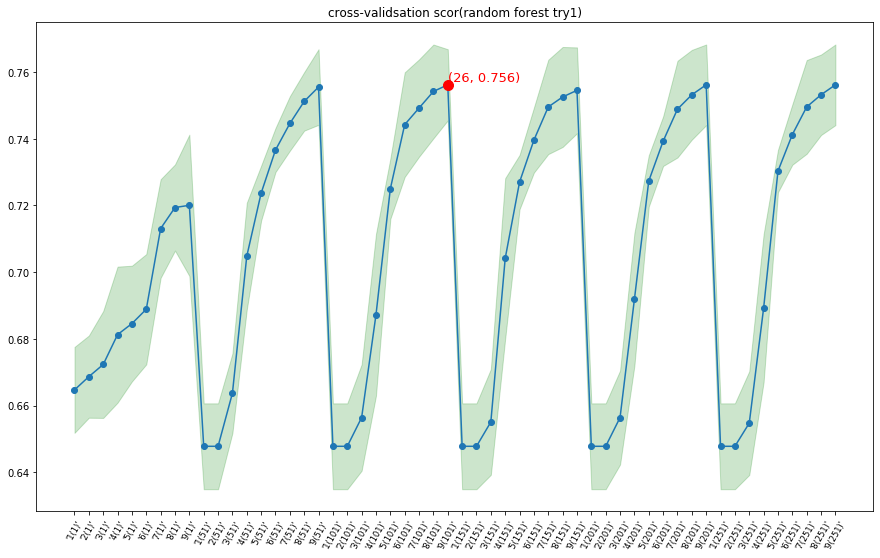

In [25]:
x_label = []
for n in range(1, 300, 50):
    for max_depth in range(1,10):
        param = "'{}({})'".format(max_depth, n)
        x_label.append(param)

plt.figure(figsize=(15,9))
plt.title("cross-validsation scor(random forest try1)")
plt.plot(x_label, check_ran_mean, "o-")
plt.fill_between(x_label, np.array(check_ran_mean) - np.array(check_ran_std),
                 np.array(check_ran_mean) + np.array(check_ran_std), alpha=0.2, color="g")
plt.plot(check_ran_mean.index(max(check_ran_mean)), max(check_ran_mean), 'ro', ms=10)
plt.text(check_ran_mean.index(max(check_ran_mean)), max(check_ran_mean)+0.001, "({}, {})".format(
    check_ran_mean.index(max(check_ran_mean)), round(max(check_ran_mean), 3)), fontdict={"size": 13, "color": "r"})
plt.xticks(rotation=60, fontsize='small')
plt.show()

### try 2

In [26]:
check_ran_mean, check_ran_std = extra_tree_check(range(1, 300, 10), [None])

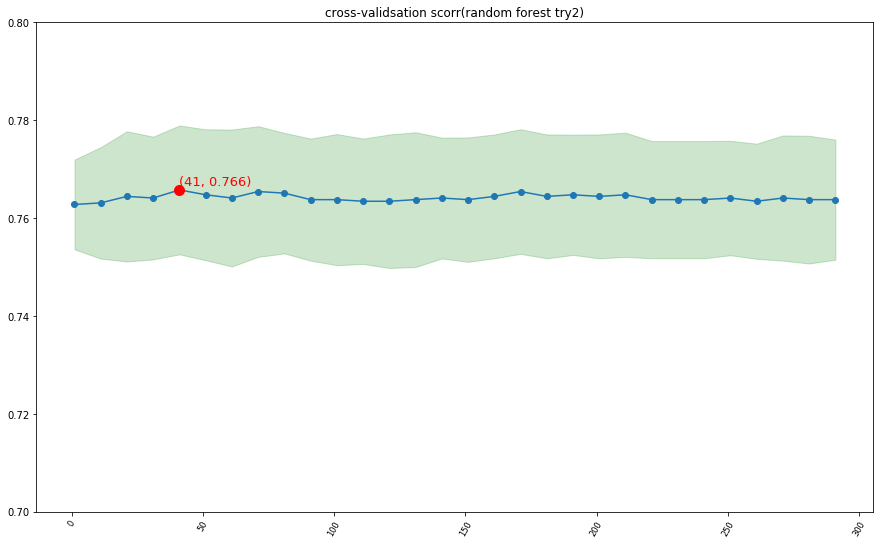

In [27]:
x_label = list(range(1, 300, 10))

plt.figure(figsize=(15,9))
plt.title("cross-validsation scorr(random forest try2)")
plt.plot(x_label, check_ran_mean, "o-")
plt.fill_between(x_label, np.array(check_ran_mean) - np.array(check_ran_std),
                 np.array(check_ran_mean) + np.array(check_ran_std), alpha=0.2, color="g")
plt.plot(x_label[check_ran_mean.index(max(check_ran_mean))], max(check_ran_mean), 'ro', ms=10)
plt.text(x_label[check_ran_mean.index(max(check_ran_mean))], max(check_ran_mean)+0.001, "({}, {})".format(
    x_label[check_ran_mean.index(max(check_ran_mean))], round(max(check_ran_mean), 3)), fontdict={"size": 13, "color": "r"})
plt.xticks(rotation=60, fontsize='small')
plt.ylim(0.7,0.8)

plt.show()

## 14. Gradient boosting(lightgbm)

- touched parameter
     - try 1 : n_estimater (1 to 300 but skip size 40), max_depth (1 to 10)
     - try 2 :  n_estimater (1 to 300 but skip size 1o), max_depth (1)
- test : 5 fold validation score

In [28]:
# make def for random forest
def gradient_boosting_check(list1, list2):
    check_boo_mean = []
    check_boo_std = []
    for n in list1:
        for max_depth in list2:
            clf_ran = Pipeline(steps=[('preprocessor', preprocessor),
                                      ('classifier', lightgbm.LGBMClassifier(n_estimators=n, max_depth = max_depth, random_state=0))])
            model_ran = clf_ran.fit(X, y)
            cv = KFold(5, shuffle=True, random_state=0)
            check = cross_val_score(model_ran, X, y, scoring="accuracy", cv=cv)
            check_boo_mean.append(check.mean())
            check_boo_std.append(check.std())
    return check_boo_mean, check_boo_std

### try 1

In [29]:
check_boo_mean, check_boo_std = gradient_boosting_check(range(1, 300, 50), range(1,10))

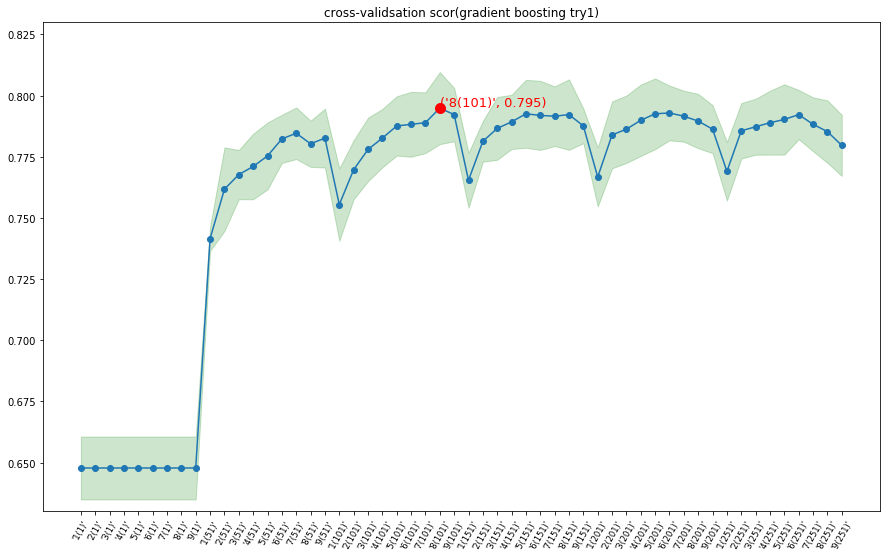

In [30]:
x_label = []
for n in range(1, 300, 50):
    for max_depth in range(1,10):
        param = "'{}({})'".format(max_depth, n)
        x_label.append(param)

plt.figure(figsize=(15,9))
plt.title("cross-validsation scor(gradient boosting try1)")
plt.plot(x_label, check_boo_mean, "o-")
plt.fill_between(x_label, np.array(check_boo_mean) - np.array(check_boo_std),
                 np.array(check_boo_mean) + np.array(check_boo_std), alpha=0.2, color="g")
plt.plot(x_label[check_boo_mean.index(max(check_boo_mean))], max(check_boo_mean), 'ro', ms=10)
plt.text(x_label[check_boo_mean.index(max(check_boo_mean))], max(check_boo_mean)+0.001, "({}, {})".format(
    x_label[check_boo_mean.index(max(check_boo_mean))], round(max(check_boo_mean), 3)), fontdict={"size": 13, "color": "r"})
plt.xticks(rotation=60, fontsize='small')
plt.ylim(0.63,0.83)

plt.show()

### try 2

In [31]:
check_boo_mean, check_boo_std = gradient_boosting_check(range(1, 300, 10), [1])

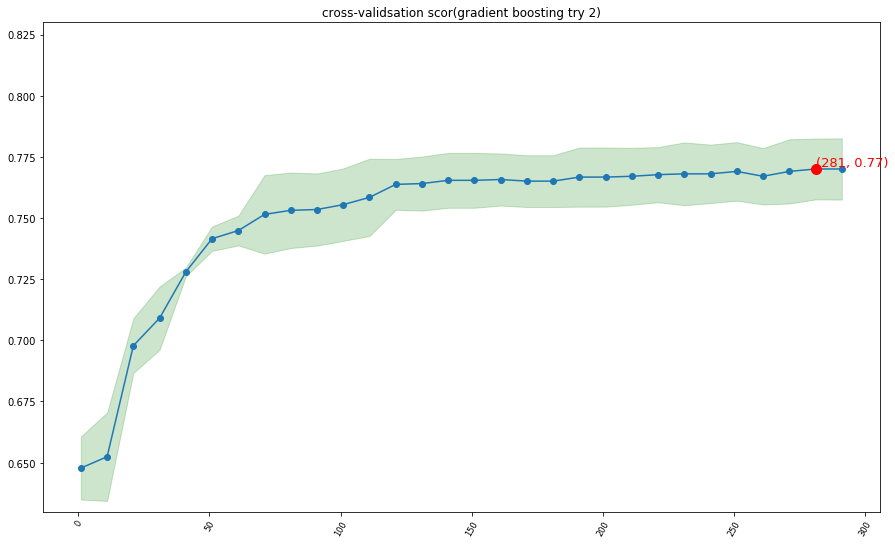

In [32]:
x_label = list(range(1, 300, 10))

plt.figure(figsize=(15,9))
plt.title("cross-validsation scor(gradient boosting try 2)")
plt.plot(x_label, check_boo_mean, "o-")
plt.fill_between(x_label, np.array(check_boo_mean) - np.array(check_boo_std),
                 np.array(check_boo_mean) + np.array(check_boo_std), alpha=0.2, color="g")
plt.plot(x_label[check_boo_mean.index(max(check_boo_mean))], max(check_boo_mean), 'ro', ms=10)
plt.text(x_label[check_boo_mean.index(max(check_boo_mean))], max(check_boo_mean)+0.001, "({}, {})".format(
    x_label[check_boo_mean.index(max(check_boo_mean))], round(max(check_boo_mean), 3)), fontdict={"size": 13, "color": "r"})
plt.xticks(rotation=60, fontsize='small')
plt.ylim(0.63,0.83)

plt.show()

## 15. Compare the test values
|Model|Cross-validation score|
|-|-|
|Logistic regression|0.781|
|Decision tree|0.776|
|Ensemble|0.766|
|Gradient boosting|<span style="color:red">**0.795**</span>|

## 16. final model
- propose gradient boosting model as a final one based on cross-validation score

In [33]:
# Fitting
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', lightgbm.LGBMClassifier(n_estimators=101, max_depth=8, random_state=0))])
model_final = clf.fit(X, y)

In [34]:
# 5 fold cross-validation score
model_final = clf.fit(X, y)
cv = KFold(5, shuffle=True, random_state=0)
check = cross_val_score(model_final, X, y, scoring="accuracy", cv=cv).mean()
check

0.7949002229470747

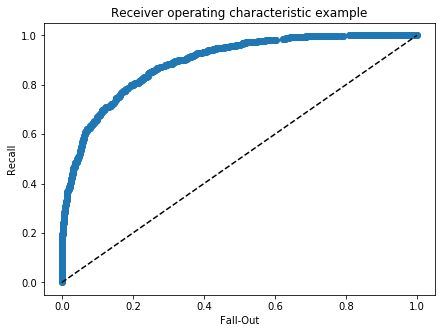

In [35]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y, model_final.predict_proba(X)[:, 1])

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, 'o-')
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.xlabel('Fall-Out')
plt.ylabel('Recall')
plt.title('Receiver operating characteristic example')
plt.show()

In [36]:
auc(fpr, tpr)

0.8907442383063906

## 17. Feature importance

- random forest serve the technic for showing fearure importance base on mean of information gain

In [37]:
# define random forest model 
def preprocess_forest(selecshop_df):
    X_category = selecshop_df.iloc[:, 0:3]
    X_numeric = selecshop_df.iloc[:, 3:4]
    enc = OneHotEncoder(handle_unknown='ignore')
    stan = StandardScaler()
    X_enc = enc.fit(X_category)
    X_stan = stan.fit(X_numeric)
    X_dummy = X_enc.transform(X_category).toarray()
    X_standard = X_stan.transform(X_numeric)
    X2 = np.hstack([X_dummy, X_standard])
    y2 = np.array(selecshop_df.iloc[:, -2:-1])
    y2 = y2.reshape(1, len(y))
    y2 = y2[0]
    return X2, y2, X_enc, X_stan

In [38]:
X2, y2, X_enc, X_stan = preprocess_forest(selecshop_df)

In [39]:
# extract importances
forest = ExtraTreesClassifier(n_estimators=10, random_state=0)
forest.fit(X2, y2)
importances = forest.feature_importances_

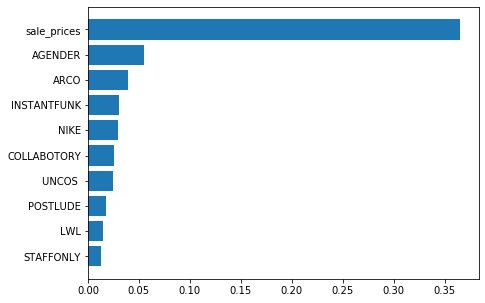

In [40]:
# show plt
X_dummy_name = X_enc.categories_
X_standard_name = np.array("sale_prices")
X_name = np.hstack([X_dummy_name[0], X_dummy_name[1],
                    X_dummy_name[2], X_standard_name])
idx = np.argsort(importances)

plt.figure(figsize=(7, 5))
plt.barh(X_name[idx][-10:], importances[idx][-10:])
plt.show()

### 18.  Practical use

In [42]:
# Show the list of each category
X_numeric =selecshop_df.iloc[:, 3:4]
usage = list(X_enc.categories_[0])
pro_type = list(X_enc.categories_[1])
brand = list(X_enc.categories_[2])
price = "min - {}, max - {}".format(min(X_numeric.sale_prices), max(X_numeric.sale_prices))  

print("* usage : ", ', '.join(usage))
print(" ")
print("* type : ", ', '.join(pro_type))
print(" ")
print("* brand : ", ', '.join(brand))
print(" ")
print("* price : ", price)

* usage :  BEAUTY, LIFE, MEN, WOMEN
 
* type :  ANKLE BOOTS, ANKLETS, ATHLETICS, BACKPACK, BAGGY, BALL CAP, BEANIE, BELT, BERET, BLAZER, BLOUSE, BOOTCUT, BOY FRIEND, BRACELETS, BROOCH/PENDANT, BUKET, Bottom, CAP, CARD CASE, CARDIGAN, CASHMERE, CHINO, CLUTCH, CLUTCHE, COAT, CROPPED, CROSS BAG, DENIM, EARRINGS, ECOBAG, FABRIC WATCH, FASHION ACC, FLARE, FLIP-FLOP, GLOVES, GRAPHIC TEE, HAIR ACC, HIGHTOP, HOODIE, JACKET, JEWERLY, JUMPER, JUMPSUIT, KEY RING, LACE-UP, LEATHER, LEATHER JACKET, LEATHER WATCH, LEGGINGS, LONG SKIRT, LONG-SLEEVE SHIRTS, LONG-SLEEVE TEE, LOWTOP, MAXIS, MESSENGER, METALLIC WATCH, MIDDLE-LENGTH SKIRT, MINI SKIRT, MINIS, MUFFLERS, NECKLACE, PADDING, PEDORA / BERET, POUCH, PULLOVER, RINGS, ROBE, SCARVES, SCARVES / MUFFLER, SET, SHIRTS, SHORT-SLEEVE SHIRTS, SHORT-SLEEVE TEE, SHORTS, SHOULDER, SHOULDER BAG, SKINNY, SLACKS, SLEEVELESS, SLEEVELESS TEE, SLIPPERS/MULES, SNEAKERS, STRAIGHT, SWEATPANTS, TIE, TOPS, TOTE, TOTE BAG, TURTLE-NECK, TURTLENECK, VEST, WALLET, WIDE LEG

In [43]:
# make test X
test = [{"gender": "MEN", "products": "CAP",
         "brands": "DEVIWEAR", "sale_prices": "40000"}]
test = pd.DataFrame(test)

In [44]:
test

,gender,products,brands,sale_prices
0,MEN,CAP,DEVIWEAR,40000


In [45]:
# prediction
model_final.predict(test)

array([0])